![image.png](https://imgur.com/9Hg689V.png)

$$P(L, K) = b * L^\alpha * K^{(1 - \alpha)}$$

-> Lấy `Ln` 2 vế:

$$ ln(P) = ln(b) + \alpha * ln(L) + (1 - \alpha) * ln(K) $$
$$ ln(P) - ln(K) = ln(b) + \alpha * ( ln(L) - ln(K) ) $$

$$ y = b' + \alpha * X $$ 
$$ b' = ln(b) $$

#### Find `alpha` and `b`

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
# Input data
DataFrame = pd.read_excel('Cobb-Douglas.xls', header=None, skiprows=1)

DataFrame = np.asarray(DataFrame[:])

n = DataFrame.shape[0]

In [3]:
# Mã hoá đầu vào sau khi lấy ln
# X
L = DataFrame[:, 2].reshape(n, )
K = DataFrame[:, 3].reshape(n, )

X = np.log(L) - np.log(K)
X = X.reshape(n, -1)

# y
P = DataFrame[:, 1].reshape(n, )
y = np.log(P) - np.log(K)

In [4]:
# # Create random b and alpha
# b = np.random.rand()

# alpha = np.random.rand()
# weight = np.array([np.log(b), alpha]).reshape(2, 1)

In [5]:
# weight

In [6]:
# Vecto hoa X
ones = np.ones((X.shape[0], 1))
X = np.concatenate((X, ones), axis = 1)

### Cách 1: Tìm Theta bằng Normal Equation
 
$$\theta = \left(X^{\rm T}X\right)^{-1} \left(X^{\rm T}y \right) =  A * c $$

In [7]:
def normal_equation(X, y):

    A = np.dot(X.T, X)
    c = np.dot(X.T, y)
    
    return np.dot(np.linalg.inv(A), c)

In [8]:
W = normal_equation(X, y)
W

array([-1.49222933,  0.10811964])

### Cách 2: Tìm Theta bằng Gradient 

#### Loss function

$$\mathcal{E}(\hat{y}, y) = \frac{1}{2N} \sum_{i=1}^N (\hat{y}^{(i)}-y^{(i)})^2 $$

In [9]:
def loss_function(X, y, w):
    y_hat = np.dot(X, w)
    return np.sum((y_hat - y)**2) / (2.0 * n)

#### Véc-tơ hóa hàm tính grad

Với $i = 1...m $ và $j = 1...n$ xét

$$ \frac{\partial \mathcal{E}}{\partial w_j} = \frac{1}{N}\sum_i x_j^{(i)}(\hat{y}^{(i)}-y^{(i)}) $$

In [10]:
def grad_function(weights, X, y):

    N, D = X.shape
    y_hat = np.dot(X, weights)
    error = y_hat - y
    
    return np.dot(np.transpose(X), error) / float(N)

#### Tính dựa trên Gradient Descent

Xấp xỉ giá trị $\theta$ như sau

$$ \hat{\theta} := \hat{\theta} - \alpha * \left( h_\theta(x^{(i)}) - y^{(i)} \right)x_j^{(i)}$$

In [11]:
loss_history = []

def np_solve_via_gradient_descent(X, y, print_every=500,
                               niter=5000, alpha=0.1):
    '''
    Given `X` - matrix of shape (N,D) of input features
          `y` - target y values
    Solves for linear regression weights.
    Return weights after `niter` iterations.
    '''
    N, D = np.shape(X)
    # initialize all the weights to zeros
    w = np.zeros([D])
    for k in range(niter):
        
        #TODO: Complete the below followed the above expressions
        dw = grad_function(w, X, y)
        w = w - alpha*dw
        loss = loss_function(X, y, w)
        loss_history.append(loss)
        if k % print_every == 0:
            print('Weight after %d iteration: %s' % (k, str(w)))
    return w

In [12]:
opt_w = np_solve_via_gradient_descent(X, y)

Weight after 0 iteration: [-0.00441434  0.0279148 ]
Weight after 500 iteration: [-0.5160736   0.22090572]
Weight after 1000 iteration: [-0.83915572  0.18357647]
Weight after 1500 iteration: [-1.05530608  0.15860222]
Weight after 2000 iteration: [-1.19991629  0.1418938 ]
Weight after 2500 iteration: [-1.2966643   0.13071544]
Weight after 3000 iteration: [-1.36139123  0.12323682]
Weight after 3500 iteration: [-1.40469523  0.11823343]
Weight after 4000 iteration: [-1.43366674  0.11488603]
Weight after 4500 iteration: [-1.45304943  0.11264653]


In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_history[:])
plt.show()

<Figure size 640x480 with 1 Axes>

### Dùng Tensorflow   

$$ y = b' + \alpha * X $$ 
$$ b' = ln(b) $$

#### Find b' and alpha 

In [14]:
dimension = X.shape[1]
learning_rate = 0.1
lost_history = []
training_epochs = 5000

X_train = X
y_train = np.asarray(y).reshape(-1, 1)

In [15]:
# Placeholder for pass data
X = tf.placeholder(tf.float32, [None, dimension])
y = tf.placeholder(tf.float32, [None, 1])

# Trainable weights
w = tf.Variable(tf.ones([dimension, 1]))

In [16]:
# Xây dựng mô hình hồi quy tuyến tính 

def tf_lr_hypothesis(X, w):
    return tf.matmul(X, w)

In [17]:
# Xây dựng hàm cost (loss)

def tf_mse_cost(Y_hat, Y):
    return tf.reduce_mean(tf.square(Y_hat - Y) / 2)

Y_hat = tf_lr_hypothesis(X, w)
loss = tf_mse_cost(Y_hat, y)

In [18]:
# Viết hàm train 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [19]:
init = tf.global_variables_initializer()

sess = tf.Session()

In [20]:
# Training

sess.run(init)

for epoch in range(training_epochs):
    sess.run(optimizer, feed_dict={X: X_train, y: y_train})
    
    test_loss = sess.run(loss, feed_dict={X: X_train, y: y_train})
    lost_history.append(test_loss)
    
    if (epoch + 1) % 500 == 0:
        print("Epoch:", epoch + 1, "| Cost:", test_loss)

Epoch: 500 | Cost: 0.026590014
Epoch: 1000 | Cost: 0.01998719
Epoch: 1500 | Cost: 0.01703179
Epoch: 2000 | Cost: 0.015708968
Epoch: 2500 | Cost: 0.015116878
Epoch: 3000 | Cost: 0.014851861
Epoch: 3500 | Cost: 0.014733243
Epoch: 4000 | Cost: 0.014680147
Epoch: 4500 | Cost: 0.014656384
Epoch: 5000 | Cost: 0.014645745


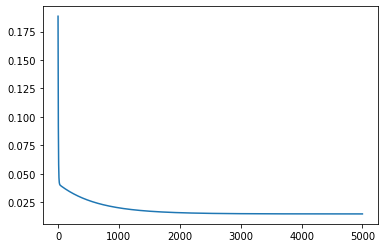

In [21]:
import matplotlib.pyplot as plt

plt.plot(lost_history[:])
plt.show()

In [22]:
sess.run(w)

array([[-1.4462192 ],
       [ 0.11343569]], dtype=float32)